uniform prior for x, y, 1/(1+beta) and 1/(1+gamma)

In [1]:
import time as ti
import loompy as lp
import pandas as pd

import pickle
import multiprocessing
from multiprocessing import Pool
# Scientific computing imports
import numpy as np
from numpy.fft import irfftn
from numpy.random import choice
from scipy.stats import rv_discrete, poisson, nbinom, gaussian_kde
import matplotlib.pyplot as plt

import scipy 
from scipy import integrate

# PyMC3-related imports
import pymc3 as pm
import theano.tensor as tt

# Plotting
import matplotlib.pyplot as plt
import arviz as az
import matplotlib as mpl

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
%cd loom/smc_results/four

/home/ggorin/projects/GVFP_2021/loom/smc_results/four


## Functions

In [5]:
# Utility function that converts between (x, y) qualitative regime coordinates to original parameters.
def convert_xy_to_params(x, y, beta, gamma, K_avg):
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return a, kappa, theta


# Sample from flattened 2D probability distribution p. 
# mx = [mx0, mx1] is the shape of the 2D domain we're sampling.
def sample_from_p(mx, num_data_points, p_flat):
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M


# Get maximum of a 2D array
def get_2D_max(array):
    return np.unravel_index(array.argmax(), array.shape)


# Get KDE for smooth-looking heatmaps.
def get_2D_KDE(x_stats, y_stats, x_min=0, x_max=1, y_min=0, y_max=1):
    num_pts = 100                          # hyperparameter
    x_arg = np.linspace(x_min, x_max, num_pts)
    y_arg = np.linspace(y_min, y_max, num_pts)

    X_arg, Y_arg = np.meshgrid(x_arg, y_arg, indexing='ij')      # grid of points      X0, X1

 
    positions = np.vstack([X_arg.ravel(), Y_arg.ravel()])
    kernel = gaussian_kde([x_stats, y_stats])
    KDE = np.reshape(kernel(positions).T, X_arg.shape)
    return KDE, x_arg, y_arg
    

In [6]:
# Constitutive model likelihood function.
def get_Poiss_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    K_avg = (a*theta)/kappa
    mu_N, mu_M = K_avg/beta, K_avg/gamma
    
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')
    
    return poisson.pmf(X_N, mu_N)*poisson.pmf(X_M, mu_M)


# Mixture model likelihood function.
def get_NB_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = np.exp(- (a/kappa)*np.log(1 - theta*(g[0]/beta + g[1]/gamma)))
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss

In [7]:
# Get 2 species GOU generating function using ODE method
def get_gf_GOU_2sp_ODE(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 1, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1
    

    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    return gf


# Get Pss for 2 species GOU model via ODE method
def get_GOU_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Combines the above functions into one to reduce overhead associated with Python function calls.
# Helpful when doing expensive posterior sampling (since many likelihood function calls are required).
def ll_GOU(phi, mx, data):
    # Get parameters
    x, y, z, q = phi
    beta = 1/z-1
    gamma = 1/q-1
    K_avg = 1
    
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    
    params = [beta, gamma, a, kappa, theta]
    
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    beta_0 = beta
    beta_1 = gamma
    
    c0 = (g[0]) + (beta_0/(beta_1 - beta_0))*(g[1])       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g[1])   
    
    min_fudge, max_fudge = 1, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    
    q0 = np.zeros((c0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    q1 = np.zeros((c0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0[:] = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1[:] = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1

    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result

In [8]:
# ODE for 2 species CIR model
def f_2sp(q, t, c0, c1, params):
    beta_0, beta_1, a, kappa, theta = params
    result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
    return result


# Vectorized RK4 implementation for 2 species CIR model
def RK4_2sp(q, f, t, c0, c1, step_size, param):
    j1 = f(q, t, c0, c1, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  
    
    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
    return q_new


# Get 2 species CIR generating function using ODE method
def get_gf_CIR_2sp(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 1, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
     
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    
    # Solve ODE using RK4 method 
    for i in range(0, num_tsteps):
        t = i*dt
        q[:,i+1] = RK4_2sp(q[:,i], f_2sp, t, c0, c1, dt, params)
        
    integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp((a*theta/kappa)*integral)               # get generating function
    return gf


# Get Pss for 2 species CIR model via ODE method
def get_CIR_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_CIR_2sp(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Log likelihood of CIR model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_CIR(phi, mx, data):
    # Get parameters
    x, y, z, q = phi
    beta = 1/z-1
    gamma = 1/q-1
    K_avg = 1
    
    # Convert from (x, y) to original parameters
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta

    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_CIR_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result

In [9]:
# This class is necessary for interfacing with PymC3.

class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, mx, data, likelihood):
        
        # add inputs as class attributes
        self.mx = mx
        self.data = data
        self.likelihood = likelihood
        
    def perform(self, node, inputs, outputs):
        
        phi, = inputs # this contains parmeters
        logl = self.likelihood(phi, self.mx, self.data) # calls the log-likelihood function
        outputs[0][0] = np.array(logl) # output the log-likelihood

In [10]:
# This function gets parameter posteriors via smc.
def get_parameter_posteriors_smc(string_ID, mx, data, ll_func, draws_=1000, chains_=2, cores_=2):
    """"Arguments changed for sample_smc function. Here is pymc3 3.11"""
    # Parameter bounds
    epsilon = 0.005
    x_min, x_max = epsilon, 1-epsilon
    y_min, y_max = epsilon, 1-epsilon
    
    # Define log likelihood
    logl_op = LogLike(mx, data, ll_func)
    def logl_fun(phi):
        return logl_op(phi)
    
    # Define PyMC3 model
    model = pm.Model()
    with model:
        # Priors
        x_ = pm.Uniform('x', lower=x_min, upper=x_max)
        y_ = pm.Uniform('y', lower=y_min, upper=y_max)
        z_ = pm.Uniform('z', lower=x_min, upper=x_max)
        q_ = pm.Uniform('q', lower=y_min, upper=y_max)

        phi = tt.as_tensor_variable([x_, y_, z_, q_])

        # Likelihood
        pm.Potential('likelihood', logl_fun(phi))
        
        
    # Run PyMC3 model
    start_time = ti.time()
    with model:
        trace = pm.sample_smc(draws = draws_, chains = chains_, cores = cores_)
    #print("--- %s seconds ---" % (ti.time() - start_time))
        
    # Plot and save trace
    #with model:
        #axes = az.plot_trace(trace)
        #fig = axes.ravel()[0].figure
        #fig.savefig("smc_results/trace_"+string_ID+".png", bbox_inches='tight')
        #fig.savefig("trace_"+string_ID+".pdf", bbox_inches='tight')
        
    return trace
  

In [11]:
def smc_wrapper(Input):
    data, gene_ID, model = Input
    d_N, d_M = data
    mx = [np.max(d_N)+10,np.max(d_M)+10]
    
    if model == "CIR":
        ID = gene_ID+"_CIR"
        trace = get_parameter_posteriors_smc(gene_ID+"_CIR", mx, data, ll_func=ll_CIR, chains_=1, cores_=1)
    else:
        ID = gene_ID+"_GOU"
        trace = get_parameter_posteriors_smc(gene_ID+"_GOU", mx, data, ll_func=ll_GOU, chains_=1, cores_=1)

    with open(ID+'_trace.pickle', 'wb') as f:
        pickle.dump(trace, f)

    return

## MCMC

In [12]:
!pwd

/home/ggorin/projects/GVFP_2021/loom/smc_results/four


In [22]:
samples = ['allen_C01_glu','allen_B08_glu','allen_H12_glu','allen_F08_glu']
g_ext = ['App', 'Cyfip2', 'Gnaq', 'Grin2b', 'Gsk3b', 'Kifap3', 'Mycbp2',
       'Prrc2c', 'Unc80']
g_gou = ['Adcy2', 'Atxn1', 'Cdh12', 'Edil3', 'Igf1r', 'Kcnk2', 'Mbnl2',
       'Meg3', 'Plxna4', 'Satb1', 'Scai', 'Sez6l', 'Slc35f1']
g_cir = ['Cox6b1', 'Mdh1', 'Ndfip1', 'Ndfip2', 'Pitpnc1', 'Slc24a3',
       'Stmn3']
genes =  g_gou + g_cir + g_ext
# 
# genes = ['Cdh12', 'Edil3','Kcnk2']

In [23]:
finished_genes = ['Scai','Cox6b1','Mdh1','Ndfip1', 'Ndfip2', 'Pitpnc1' 'Slc24a3','Stmn3','Igf1r','Adcy2','Atxn1']


In [24]:
datas = {}
for sample in samples:
    with lp.connect('../../'+sample+'.loom') as ds:
        S = ds.layers['spliced'][:]
        U = ds.layers['unspliced'][:]
        gene_names = ds.ra['gene_name']
    datas[sample]= [S,U,gene_names]

In [25]:
Inputs = []
for gene in genes:
    if gene in finished_genes:
        next
    for sample in samples:
        S,U,gene_names = datas[sample]
        gene_ID = sample+"_"+gene 
        i = np.where(gene_names==gene)[0][0]
        d_M = S[i].astype(int)
        d_N = U[i].astype(int)
        data = [d_N, d_M]
        #Inputs.append((data, gene_ID, "CIR"))
        if sample == 'allen_B08_glu' and gene == 'Edil3':
            Inputs.append((data, gene_ID, "GOU"))

In [61]:
Inputs

[([array([31,  8,  5, ...,  8, 85, 20]), array([ 3,  4,  0, ...,  1,  7, 13])],
  'allen_B08_glu_Edil3',
  'GOU')]

In [63]:
smc_wrapper(Inputs[0])

Initializing SMC sampler...
Sampling 1 chain in 1 job
/home/mffang/miniconda3/envs/main/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.001
Stage:   4 Beta: 0.001
Stage:   5 Beta: 0.003
Stage:   6 Beta: 0.007
Stage:   7 Beta: 0.015
Stage:   8 Beta: 0.030
Stage:   9 Beta: 0.061
Stage:  10 Beta: 0.119
Stage:  11 Beta: 0.237
Stage:  12 Beta: 0.464
Stage:  13 Beta: 0.915
Stage:  14 Beta: 1.000


In [ ]:
with Pool(min(2,len(Inputs))) as p:
    p.map(smc_wrapper, Inputs, chunksize=1)

## BF plots

In [29]:
import cachetools


In [31]:
cachetools.lru

AttributeError: module 'cachetools' has no attribute 'lru'

In [30]:
import pickle

n_samples,n_genes = len(samples),len(genes)
BF = np.empty((n_samples,n_genes))
BF[:] = np.nan
for j,sample in enumerate(samples):
    for i,gene in enumerate(genes):
        if gene in finished_genes:
            with open(sample+"_"+gene+'_GOU_trace.pickle', 'rb') as f:
                trace_GOU = pickle.load(f)
            with open(sample+"_"+gene+'_CIR_trace.pickle', 'rb') as f:
                trace_CIR = pickle.load(f)
            BF[j,i]= (trace_CIR.report.log_marginal_likelihood - trace_GOU.report.log_marginal_likelihood)/np.log(10)

ModuleNotFoundError: No module named 'cachetools.lru'

In [ ]:
genes

In [ ]:
plt.figure(figsize=(5,10))

plt.plot([0,0],[0,28],'r-',linewidth=2)
plt.plot(BF.T,range(len(genes)),'.',markersize=20,alpha=0.7)
plt.yticks(ticks=range(len(genes)),labels=genes)

xl = plt.gca().get_xlim()
plt.plot(xl,[(len(g_ext)-0.5)]*2,'k--')
plt.plot(xl,[(len(g_ext)+len(g_gou)-0.5)]*2,'k--')
plt.xlabel(r'Bayes factor: (+) CIR, $(-) \ \Gamma$-OU)')

In [ ]:
plt.figure(figsize=(5,10))

plt.plot([0,0],[0,28],'r-',linewidth=2)
plt.boxplot(BF,positions=range(len(genes)),vert=False)
plt.yticks(ticks=range(len(genes)),labels=genes)

plt.plot(xl,[(len(g_ext)-0.5)]*2,'k--')
plt.plot(xl,[(len(g_ext)+len(g_gou)-0.5)]*2,'k--')
plt.xlabel(r'Bayes factor: (+) CIR, $(-) \ \Gamma$-OU)')

## Posteriors

In [28]:
def posteriors_mean(trace):
    
    x_stats, y_stats, z_stats, q_stats = trace['x'], trace['y'], trace['z'], trace['q']

    beta_stats = 1/z_stats-1
    gamma_stats = 1/q_stats-1
    K_avg = 1

    kappa_stats = (beta_stats + gamma_stats)*(x_stats/(1-x_stats))
    a_over_th_stats = 1/y_stats - 1
    theta_stats = np.sqrt(kappa_stats*K_avg/a_over_th_stats)
    a_stats = K_avg*kappa_stats/theta_stats
    
    x_avg, y_avg = np.mean(x_stats), np.mean(y_stats)    # posterior means
    b_avg, g_avg = np.mean(beta_stats), np.mean(gamma_stats)    # posterior means
      
    return b_avg, g_avg #, 1/np.mean(z_stats)-1, 1/np.mean(q_stats)-1

In [36]:
# This function analyzes and plots the posterior samples.
def analyze_posteriors(string_ID, trace, ax=None):
    
    x_stats, y_stats, z_stats, q_stats = trace['x'], trace['y'], trace['z'], trace['q']

    beta_stats = 1/z_stats-1
    gamma_stats = 1/q_stats-1
    K_avg = 1

    kappa_stats = (beta_stats + gamma_stats)*(x_stats/(1-x_stats))
    a_over_th_stats = 1/y_stats - 1
    theta_stats = np.sqrt(kappa_stats*K_avg/a_over_th_stats)
    a_stats = K_avg*kappa_stats/theta_stats
    
    x_avg, y_avg = np.mean(x_stats), np.mean(y_stats)    # posterior means
    b_avg, g_avg = np.mean(beta_stats), np.mean(gamma_stats)    # posterior means

    
    # KDEs
    KDE_xy, x_arg, y_arg = get_2D_KDE(x_stats, y_stats, 0, 1, 0, 1)
    b_max = np.max(beta_stats)
    g_max = np.max(gamma_stats)
    KDE_bg, b_arg, g_arg = get_2D_KDE(beta_stats, gamma_stats, 0, b_max, 0, g_max)

    KDE_x = np.sum(KDE_xy, axis=1)
    KDE_x = KDE_x/np.trapz(KDE_x, x=x_arg)
    KDE_y = np.sum(KDE_xy, axis=0)
    KDE_y = KDE_y/np.trapz(KDE_y, x=y_arg)

    KDE_b = np.sum(KDE_bg, axis=1)
    KDE_b = KDE_b/np.trapz(KDE_b, x=b_arg)
    KDE_g = np.sum(KDE_bg, axis=0)
    KDE_g = KDE_g/np.trapz(KDE_g, x=g_arg)

    # Summary statistics
    i, j = get_2D_max(KDE_xy)
    x_map, y_map = x_arg[i], y_arg[j]

    i, j = get_2D_max(KDE_bg)
    b_map, g_map = b_arg[i], g_arg[j]


    s= mpl.rcParams['lines.markersize']**2
    newsize=1*s
    """
    print("Plotting 2D heatmap in terms of (x, y)...")
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    ax.scatter(x_map, y_map, color='blue', label='MAP', s=newsize, edgecolor='white')
    ax.scatter(x_avg, y_avg, color='red', label='avg', s=newsize, edgecolor='white')
    ax.imshow(np.transpose(KDE_xy), origin='lower', extent=[0, 1, 0, 1])

    if loc==True:
        plt.legend(fontsize=18, framealpha=1)
    plt.savefig('post_2D_xy_'+string_ID+'.pdf', bbox_inches='tight')
    #plt.savefig('post_2D_xy_'+string_ID+'.png', bbox_inches='tight')

    plt.show()
    """

    #print("Plotting 2D heatmap in terms of (beta, gamma)...")
    if ax is None:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)

    ax.scatter(b_map, g_map, color='blue', label='MAP', s=newsize, edgecolor='white')
    ax.scatter(b_avg, g_avg, color='red', label='avg', s=newsize, edgecolor='white')
    ax.imshow( np.transpose(KDE_bg), origin='lower', extent=[0, b_arg[-1], 0, g_arg[-1]], aspect='auto')

    #plt.savefig('post_2D_bg_'+string_ID+'.pdf', bbox_inches='tight')
    #plt.savefig('post_2D_bg_'+string_ID+'.png', bbox_inches='tight')

    return

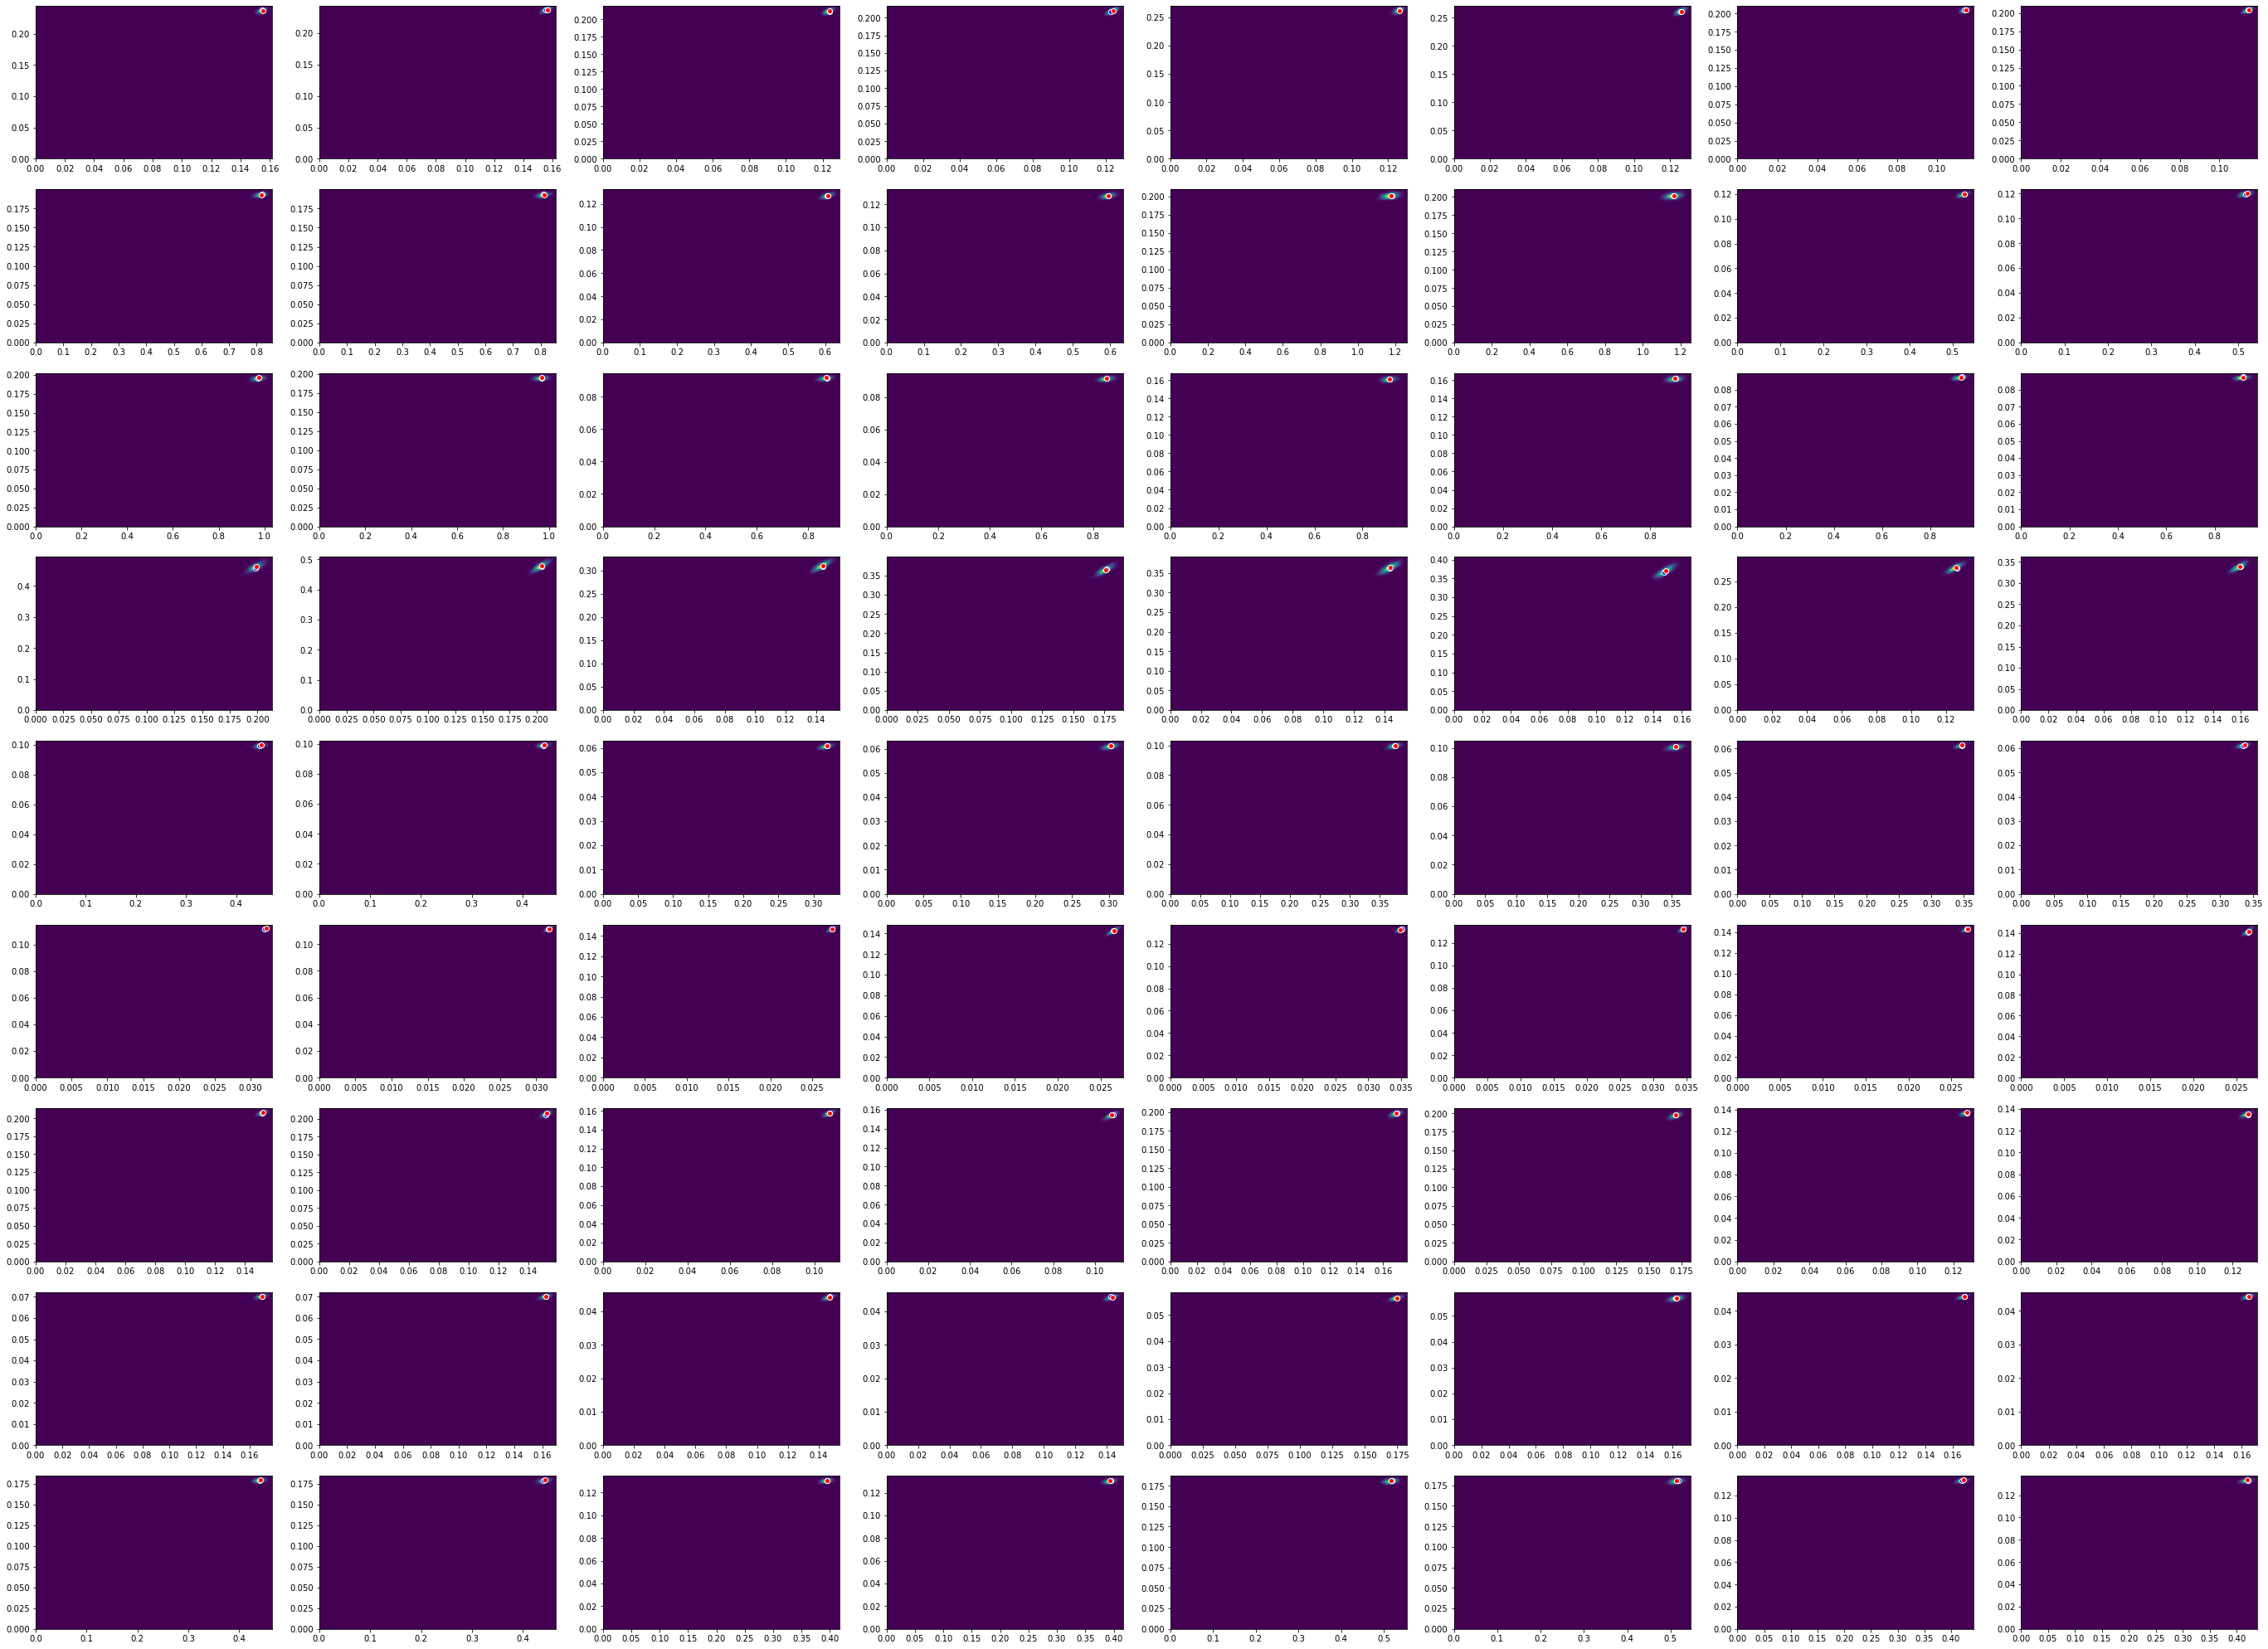

In [37]:
finished_genes = ['Scai','Cox6b1','Mdh1','Slc24a3','Stmn3', 'Atxn1', 'Igf1r','Ndfip1','Ndfip2']

n_samples,n_genes = len(samples),len(finished_genes)
GOU_bg = np.zeros((n_samples,n_genes,2))
CIR_bg = np.zeros((n_samples,n_genes,2))
bg = np.zeros((n_samples,n_genes,2))

fig, axs = plt.subplots(len(finished_genes),len(samples)*2,figsize=(len(samples)*2*6,len(finished_genes)*4))
for j,sample in enumerate(samples):
    with lp.connect('../../'+sample+'.loom') as ds:
        S = ds.layers['spliced'][:]
        U = ds.layers['unspliced'][:]
        gene_names = ds.ra['gene_name']
    for i,gene in enumerate(finished_genes):
        idx = np.where(gene_names==gene)[0][0]
        d_M = S[idx].astype(int)
        d_N = U[idx].astype(int)
        bg[j,i]=[1/np.mean(d_N),1/np.mean(d_M)]
        with open(sample+"_"+gene+'_GOU_trace.pickle', 'rb') as f:
            trace_GOU = pickle.load(f)
            GOU_bg[j,i]=posteriors_mean(trace_GOU)
            analyze_posteriors(sample+"_"+gene+'_GOU', trace_GOU, ax=axs[i,2*j])
        with open(sample+"_"+gene+'_CIR_trace.pickle', 'rb') as f:
            trace_CIR = pickle.load(f)
            CIR_bg[j,i]=posteriors_mean(trace_CIR)    
            analyze_posteriors(sample+"_"+gene+'_CIR', trace_CIR, ax=axs[i,2*j+1])

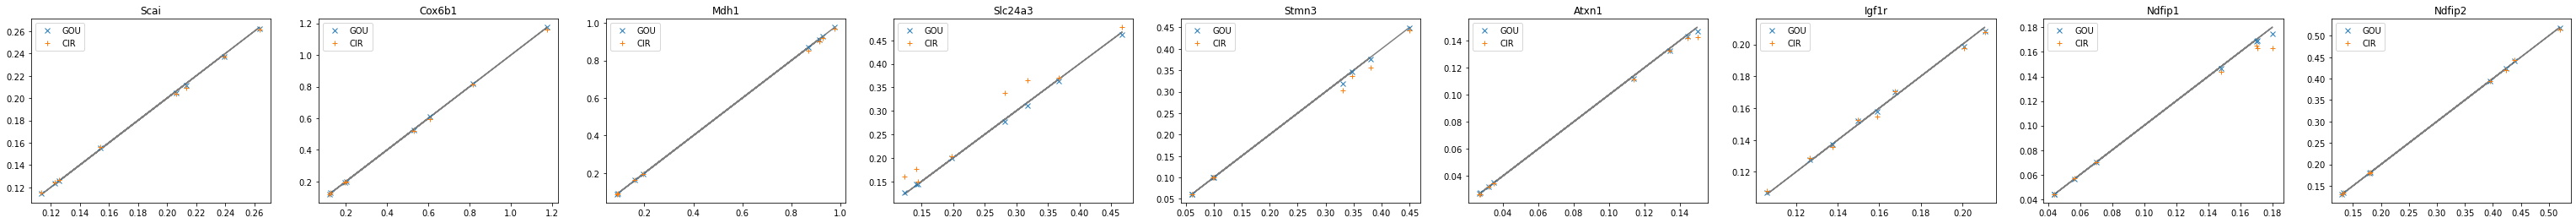

In [42]:
fig, ax = plt.subplots(1,len(finished_genes),figsize=(len(finished_genes)*6,4))
for i,gene in enumerate(finished_genes):
    ax[i].plot(bg[:,i,:].flatten(),bg[:,i,:].flatten(),color='gray')
    ax[i].plot(bg[:,i,:].flatten(),GOU_bg[:,i,:].flatten(),'x',label="GOU")
    ax[i].plot(bg[:,i,:].flatten(),CIR_bg[:,i,:].flatten(),'+',label="CIR")
    ax[i].set_title(gene)
    ax[i].legend();